In [1]:
# Common stuffs and imports
import findspark
from pyspark import SparkContext
import numpy as np
from matplotlib import pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')
findspark.init()                    #This is to automate the Java path for Spark. Needs 'findspark' library installed.


In [2]:
#define file paths and initialize spark context
centroidsPath = './centroid.txt'
pointsPath = './data.txt'
sc = SparkContext('local','PySpark Word Count')


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/26 08:02:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Read the centroids and data, split and convert to rdd
text = sc.textFile(centroidsPath).flatMap(lambda line: line.split("/n"))
init_centroids = text.map(lambda x: (x.split("\t")))
init_centroids = init_centroids.map(lambda x: [float(i) for i in x]).collect()
init_centroids = sc.broadcast(init_centroids)

#now, lets read the data
text = sc.textFile(pointsPath).flatMap(lambda line: line.split("/n"))
points = text.map(lambda x : x.split("\t"))
points = points.map(lambda x: [float(i) for i in x]).cache()
                                    

In [4]:
#This is a custom KMeans Mapper function. Description of the function is given in markdown below:
def kMeansMap (point, centroids_global):
    distances = []
    for centroid in centroids_global.value:
        dist = np.linalg.norm(np.array(point) - np.array(centroid))
        distances.append(dist)
    
    # We might have multiple centroids with the same distance, so we will select one at random
    closest_distance = np.min(distances)
    idxs = np.argwhere(distances == closest_distance).flatten().tolist()
    
    selectedIdx = np.random.choice(idxs)
    return (selectedIdx, (closest_distance,point, 1))

### Map: Explanation
- This is a custom mapper function. I take two input - the point and it also has access to the broadcast of centroids.
- The distance lis is created to hold the distances between the point and each centroids. I could have done without using list and having a variable hold the min distance but in this implementation, I can randomly break ties for an equal distances.
- Next, I pick the min distances, get all the indices (idx) corrosponding to that distance and randomly select from the list. Most of the time, the list is going to have one item.
- Finally, I return the selected Index (of assigned centroid), the distance (so that the loss calculation is easier, the point and a value 1 (for reducing later))

In [5]:
#Custom Reduce function. Description of the function is given in markdown below:
def kMeansReduce (x, y):
    keysum = x[0] + y[0]
    sum = np.add(x[1], y[1])
    countsum = x[2] + y[2]
    return (keysum, sum, countsum)

### Reduce : Explanation
-  This is preety straight forward, could have done with a lambda function as well
-  Here, I just add them by key for the points assigned to that particulaer centroid
-  We get the sum and the count for that centroid, which is going to be used in next step for averaging for new centroid

In [6]:
loss = []               #This is to store the loss values (Total distance of all points from their centroids)
max_interations = 20    #Stopping criteria: maximum number of iterations
for iteration in range(max_interations):
    
    mapped = points.map(lambda x: kMeansMap(x, init_centroids))             #map the points to the centroids
    reduced = mapped.reduceByKey(lambda x, y: kMeansReduce(x, y))           #reduce the mapped points to the centroids

    avg_centroids = reduced.map(lambda x: [i/x[1][2] for i in x[1][1]])     #calculate the average of the points
    
    init_centroids = sc.broadcast(avg_centroids.collect())                  #update the centroids
    local_cost = reduced.map(lambda x: x[1][0]).reduce(lambda x, y: x + y)  #calculate the total distance of all points from their new centroids

    loss.append(local_cost)                                                 #store the loss value

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/shuffle.py:60: UserWarning: Please install psutil to have better support with spilling


Text(0.5, 1.0, 'K-Means clustering - Sum of Squared Distance over Iterations')

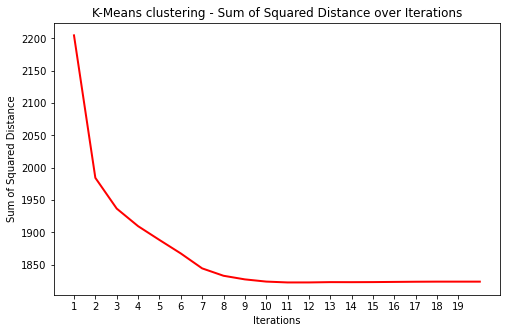

In [7]:
#Plot the loss values
fig = plt.figure()
fig.set_size_inches(8, 5)
plt.plot(range(1,21),loss, color='red', linewidth=2)
plt.xlabel('Iterations')
plt.ylabel('Sum of Squared Distance')
plt.xticks(np.arange(1, max_interations, 1))
plt.title('K-Means clustering - Sum of Squared Distance over Iterations')